## STATS 202 Kaggle In Class Competition: Property values

### Data
* 9 predictors: ID, YearBuild, SqFt, Story, Acres, Baths, Fireplaces, Zip
* 1 response: Value
* number of observations: 90
* missing values 
* candidate learning algorithms:
 * parameteric
     * multiple linear regression
     * PCR
     * Ridge, Lasso
 * nonparametric
     * spline
     * nearest neighbor
     * decision tree
     * SVM

In [66]:
library(dplyr)
library(ggplot2)
library(reshape2)

In [67]:
# Read in the data files
data = read.csv('../data/train.csv', header=T)
testInput = read.csv('../data/test.csv', header=T)
head(data)
summary(testInput)
dim(data)

ID,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
1,1990,2102,1.0,0.77,NA,1,27603,203200
2,1986,1740,1.5,0.06,3,1,27604,119096
3,1955,795,1.0,0.30,1,0,27610,71666
4,1983,1152,1.0,0.68,2,0,27616,131103
5,2003,1404,1.0,39.38,2,0,27519,4904102
6,1924,1829,1.5,0.25,3,1,27607,496425


       ID          YearBuilt         SqFt          Story           Acres       
 Min.   : 1.00   Min.   :1947   Min.   : 900   Min.   :1.000   Min.   :0.0300  
 1st Qu.: 3.25   1st Qu.:1967   1st Qu.:1068   1st Qu.:1.000   1st Qu.:0.1725  
 Median : 5.50   Median :1984   Median :1485   Median :1.000   Median :0.2150  
 Mean   : 5.50   Mean   :1977   Mean   :1571   Mean   :1.375   Mean   :0.2470  
 3rd Qu.: 7.75   3rd Qu.:1987   3rd Qu.:1856   3rd Qu.:1.938   3rd Qu.:0.2825  
 Max.   :10.00   Max.   :1995   Max.   :2678   Max.   :2.000   Max.   :0.5600  
     Baths         Fireplaces        ZIP       
 Min.   :1.000   Min.   :0.00   Min.   :27513  
 1st Qu.:1.625   1st Qu.:0.25   1st Qu.:27560  
 Median :2.000   Median :1.00   Median :27608  
 Mean   :2.050   Mean   :0.70   Mean   :27586  
 3rd Qu.:2.500   3rd Qu.:1.00   3rd Qu.:27612  
 Max.   :3.000   Max.   :1.00   Max.   :27616  

[1] 90  9

In [68]:
range(data$Zip)
range(testInput$ZIP)

[1] 27502 27617

[1] 27513 27616

In [69]:
# impute the missing value in the bath by its mean
data$Baths[is.na(data$Baths)] = round(mean(data$Baths, 
                                             na.rm=T),0)

# Treat the zip code as factor
data = data[,-1]
data$Zip = as.factor(data$Zip)
head(data)
testInput = testInput[,-1]
testInput$ZIP = as.factor(testInput$ZIP)
head(testInput)

# 

YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
1990,2102,1.0,0.77,2,1,27603,203200
1986,1740,1.5,0.06,3,1,27604,119096
1955,795,1.0,0.30,1,0,27610,71666
1983,1152,1.0,0.68,2,0,27616,131103
2003,1404,1.0,39.38,2,0,27519,4904102
1924,1829,1.5,0.25,3,1,27607,496425


YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,ZIP
1967,1752,1.00,0.29,1.5,1,27604
1987,2678,1.75,0.17,3.0,1,27613
1986,1024,2.00,0.03,1.5,0,27616
1963,2340,1.00,0.56,2.5,1,27610
1995,1104,1.00,0.51,2.0,1,27545
1947,900,1.00,0.25,1.0,0,27607


### Visualizing the data

Using Zip as id variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


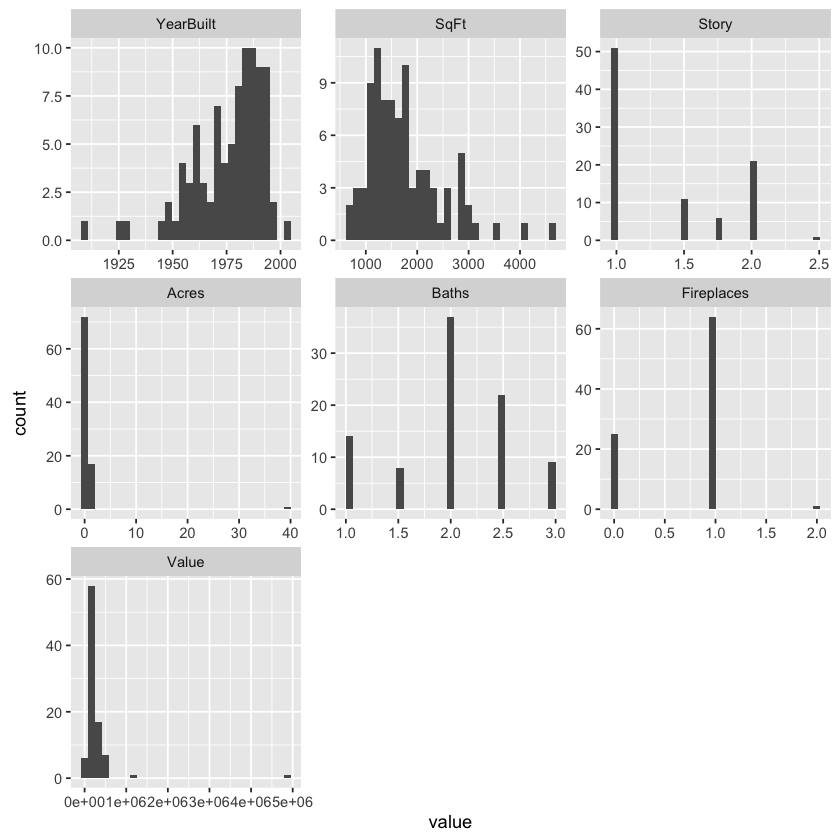

In [70]:
melt(tbl_df(data)) %>%
    ggplot(data=.) +
    aes(x=value) +
    facet_wrap(~variable,scales = "free") + 
    geom_histogram()

In [71]:
# Looks like there are high leverage points for the data in terms of acre and value
which.max(data[-5,]$Value)
which.max(data$Acres)

[1] 77

[1] 5

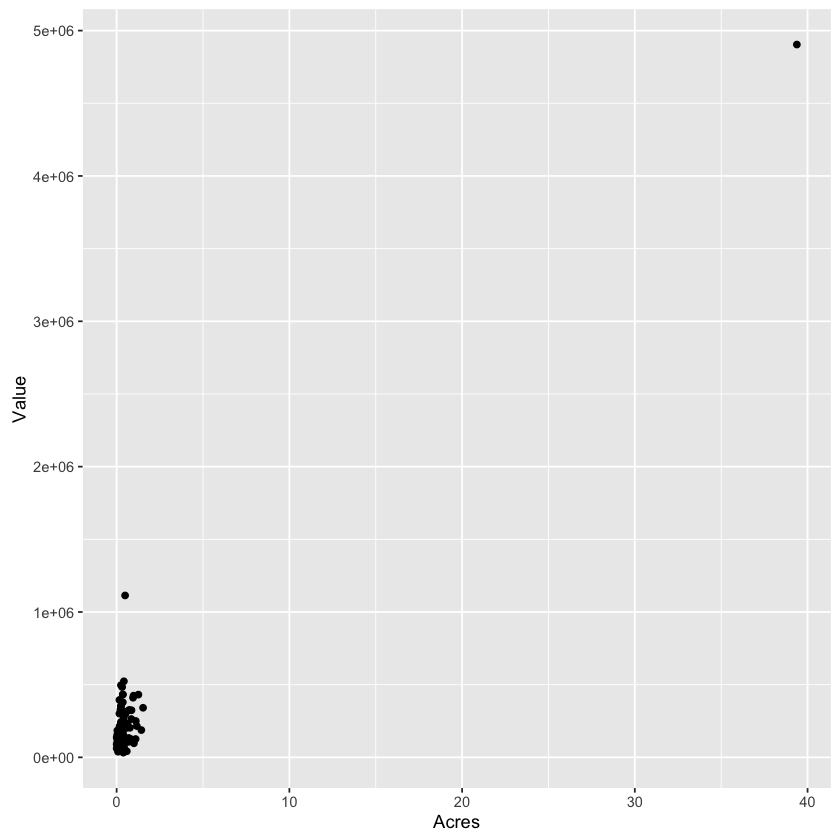

In [72]:
ggplot(aes(x=Acres, y=Value), data=data) + geom_point()

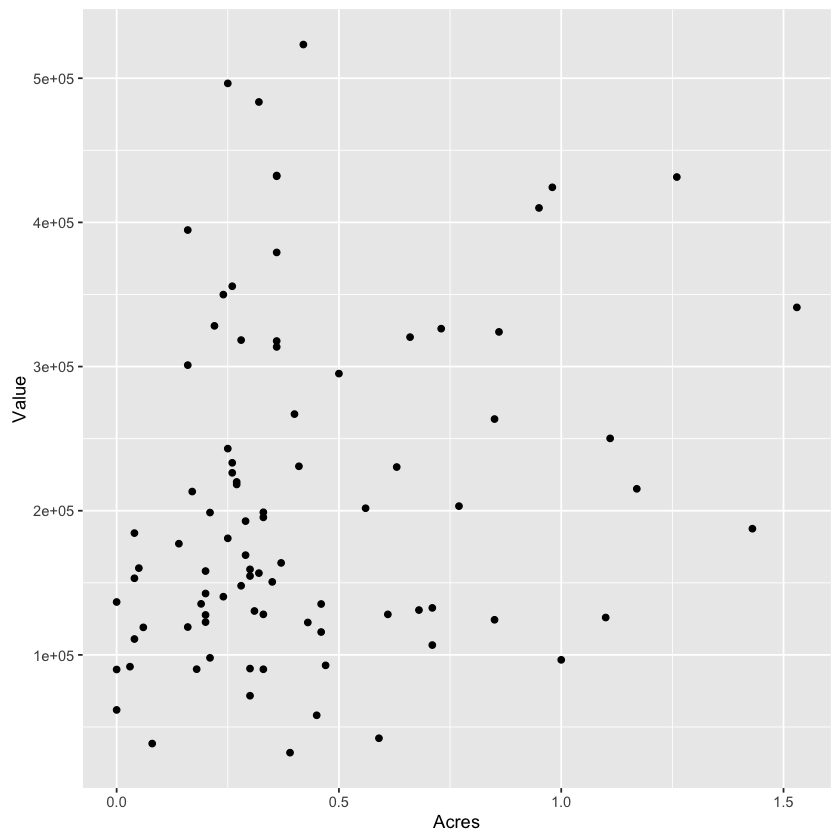

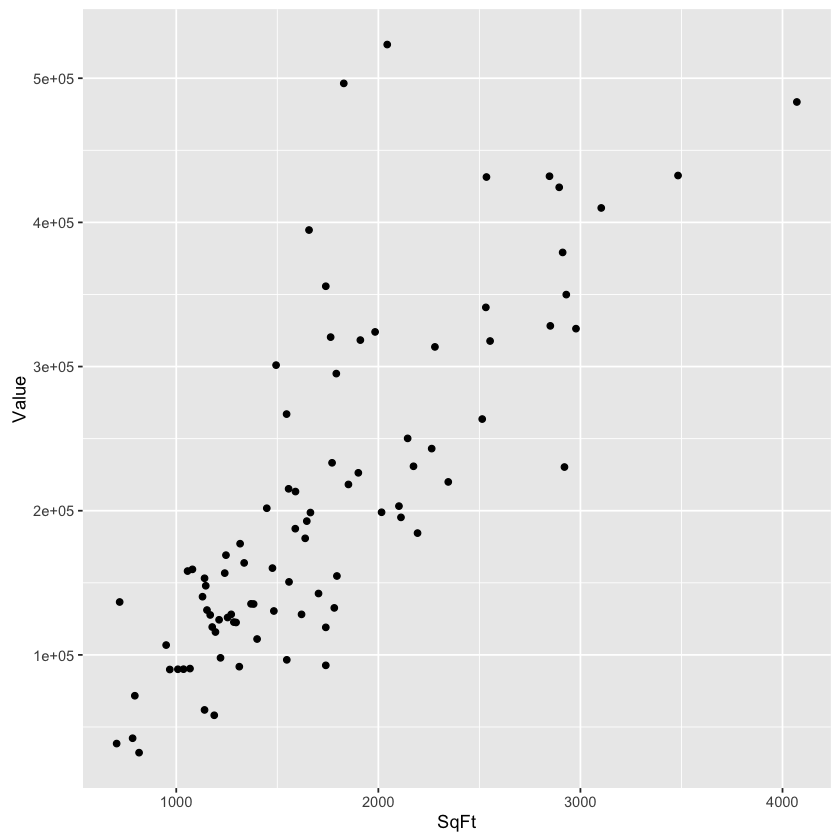

In [73]:
# Without the two leverage points:
ggplot(aes(x=Acres, y=Value), data=data[-c(5, 78),]) + geom_point()
ggplot(aes(x=SqFt, y=Value), data=data[-c(5, 78),]) + geom_point()

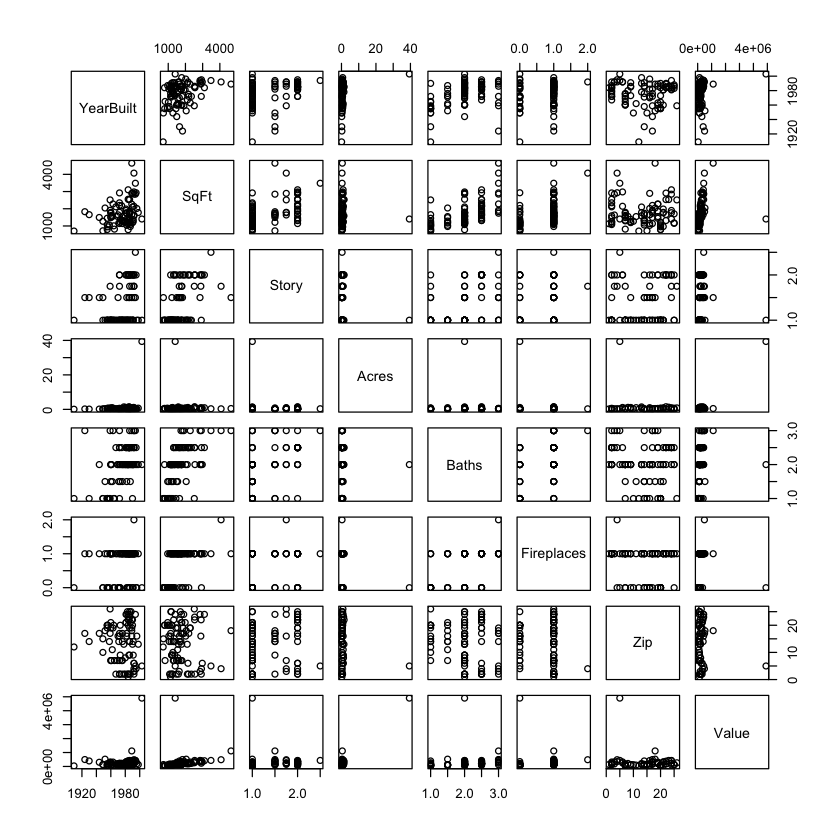

In [74]:
pairs(data)

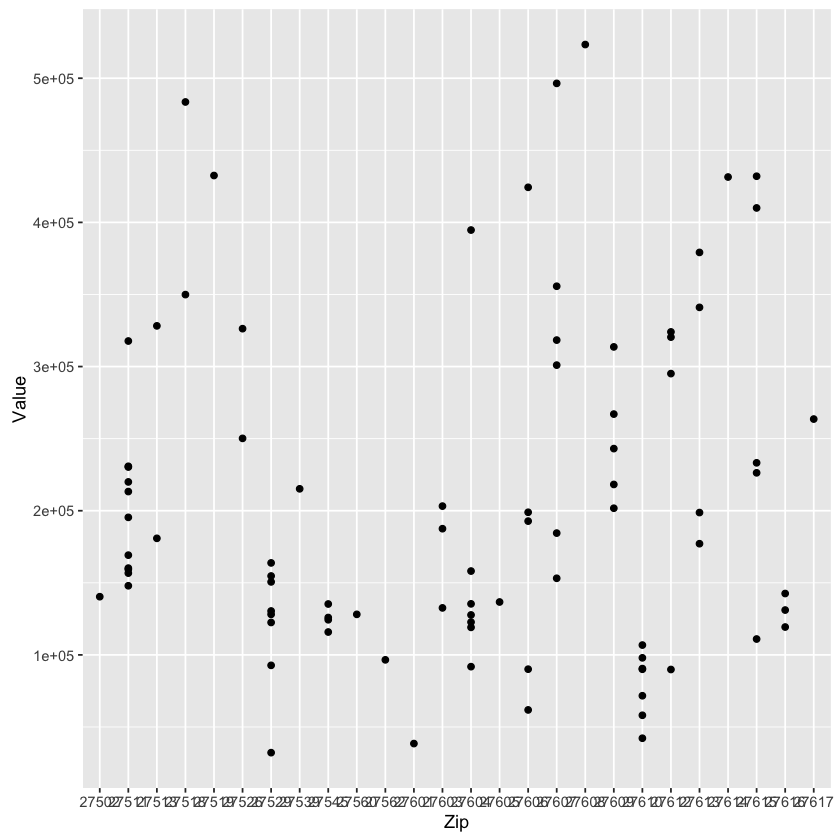

In [75]:
# Curious about whether there are clusters of ZIP-value pair 
# places with the same ZIP code tend to have similar prices
ggplot(aes(x=Zip, y=Value), data=data[-c(5, 78),]) + geom_point()

Question:
* Should we exclude the high leverage point from the data?

- The single point dominates the entire prediction! And the bulk of houses follows a normal distribution

In [76]:
data[5,] # high acres 
data[78,] # high sqft

,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
5,2003,1404,1,39.38,2,0,27519,4904102


,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
78,1989,4650,1.5,0.49,3,1,27608,1113750


In [77]:
data = data[-c(5, 78),]

## Simple linear regression (base line model)
* Based on the descriptive analysis, it was found that the property value is most correlated with SqFt and Acres

In [86]:
set.seed(1)
trainIdx = sample(1:nrow(data), round(nrow(data)*3/4, 0))
validationIdx = (-trainIdx)
lm.sqrtAcres = lm(Value~SqFt+Acres, data=data[trainIdx,])
summary(lm.sqrtAcres)
lm.sqrtAcres.pred = predict(lm.sqrtAcres, data[validationIdx,])


Call:
lm(formula = Value ~ SqFt + Acres, data = data[trainIdx, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-123930  -46872  -16296   23272  265083 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21654.12   25876.80  -0.837    0.406    
SqFt           139.71      14.11   9.903 1.83e-14 ***
Acres       -10133.74   29715.38  -0.341    0.734    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 76340 on 63 degrees of freedom
Multiple R-squared:  0.6284,	Adjusted R-squared:  0.6166 
F-statistic: 53.28 on 2 and 63 DF,  p-value: 2.859e-14


In [88]:
testError = function(pred, true) {
    print(paste("test R^2: ", 1-mean((pred-true)^2)/mean((mean(true)-true)^2)))
    print(paste("test MSE", mean((pred-true)^2)))
}
testError(lm.sqrtAcres.pred, data[validationIdx,]$Value)

[1] "test R^2:  0.379763866745206"
[1] "test MSE 3436030402.09671"


In [105]:
# baseline model (the test MSE from Kaggle is 54297.93748)
testprediction = predict(lm.sqrtAcres, data.frame(testInput))
df = data.frame(ID=seq(length(testprediction)), Predicted=round(testprediction, 0))
df
write.csv(df, file='~/Documents/Courses/STATS202/KaggleCompetition/prediction.csv', row.names = FALSE)

ID,Predicted
1,220179
2,350767
3,121105
4,299593
5,127418
6,101552
7,240574
8,124056
9,194491
10,174099


### k-fold cross validation for estimation of test error 

In [ ]:
# Cross validation

## Linear regression model with more features

In [109]:
# Using all the parameters
lm.sqrtAcresYr = lm(Value~YearBuilt+SqFt, data=data[trainIdx,])
summary(lm.sqrtAcresYr)
lm.sqrtAcresYr.pred = predict(lm.sqrtAcresYr, data[validationIdx,])
testError(lm.sqrtAcresYr.pred, data[validationIdx,]$Value)


Call:
lm(formula = Value ~ YearBuilt + SqFt, data = data[trainIdx, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-151413  -45793   -2889   35893  216479 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3634444.7  1016152.7   3.577 0.000675 ***
YearBuilt     -1869.2      519.1  -3.601 0.000626 ***
SqFt            157.1       13.3  11.819  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 69580 on 63 degrees of freedom
Multiple R-squared:  0.6913,	Adjusted R-squared:  0.6815 
F-statistic: 70.53 on 2 and 63 DF,  p-value: < 2.2e-16


[1] "test R^2:  0.340744073870359"
[1] "test MSE 3652195161.63421"


* Ridge regression analysis


In [80]:
library(glmnet)
x.train = model.matrix(Value~., data=data[trainIdx,])
x.validation = model.matrix(Value~., data=data[validationIdx,])
y.train = data[trainIdx,]$Value
y.validation = data[validationIdx,]$Value

In [81]:
head(x.train)
head(y.train)
head(x.validation)

,(Intercept),YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip27511,Zip27513,Zip27518,⋯,Zip27607,Zip27608,Zip27609,Zip27610,Zip27612,Zip27613,Zip27614,Zip27615,Zip27616,Zip27617
25,1,1992,2978,2,0.73,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
34,1,1971,1168,1,0.20,1.5,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
51,1,1987,1080,1,0.30,2.0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80,1,1981,1764,1,0.66,2.0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
18,1,1959,1911,1,0.28,3.0,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
76,1,1978,1589,1,1.43,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 326287 127708 159332 320419 318360 187539

,(Intercept),YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip27511,Zip27513,Zip27518,⋯,Zip27607,Zip27608,Zip27609,Zip27610,Zip27612,Zip27613,Zip27614,Zip27615,Zip27616,Zip27617
2,1,1986,1740,1.5,0.06,3.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,1,1989,2264,2.0,0.25,2.5,1,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
11,1,1990,1188,1.0,0.45,1.0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
14,1,1985,1212,1.5,0.85,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
23,1,1988,1178,1.0,0.16,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
24,1,1961,1620,1.0,0.61,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [82]:
# selection of the lambda by cross validation
grid = 10^seq(10, -2, length=100)
ridge.mod = cv.glmnet(x.train, y.train, alpha=0, lambda=grid,
                     thresh=1e-12)
lambda.best = ridge.mod$lambda.min
lambda.best

[1] 6579.332

In [83]:
ridge.pred = predict(ridge.mod, newx=x.validation, s=lambda.best)
1-mean((ridge.pred-y.validation)^2)/mean((mean(y.validation)-y.validation)^2)
mean((ridge.pred-y.validation)^2)

[1] 0.2996427

[1] 3879891735

In [84]:
predict(ridge.mod, newx=x.test, s=lambda.best, type='coefficients')

33 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 2275148.5833
(Intercept)       .     
YearBuilt     -1170.7162
SqFt            105.2918
Story         22383.0139
Acres         63815.0118
Baths         -2725.7676
Fireplaces    28491.9632
Zip27511     -10296.7283
Zip27513      -2690.5923
Zip27518      24701.8963
Zip27519      24501.2153
Zip27526     -47890.7606
Zip27529     -61956.0302
Zip27539          .     
Zip27545     -41777.3336
Zip27560          .     
Zip27562    -147320.0745
Zip27601     -95686.8495
Zip27603     -68437.3066
Zip27604      38556.6492
Zip27605      34772.1456
Zip27606      -1492.8531
Zip27607     120959.0454
Zip27608     232345.7426
Zip27609      15751.1885
Zip27610     -39135.0104
Zip27612      41841.4383
Zip27613        781.1013
Zip27614      64196.8235
Zip27615      11792.1413
Zip27616     -33403.7792
Zip27617     -96882.6121

## Regression tree

In [ ]:
# Regression Tree Example
library(rpart)

# grow tree 
fit <- rpart(Value~., 
   method="anova", data=data[-5,])

printcp(fit) # display the results 
plotcp(fit) # visualize cross-validation results 
summary(fit) # detailed summary of splits

# create additional plots 
par(mfrow=c(1,2)) # two plots on one page 
rsq.rpart(fit) # visualize cross-validation results 

# plot tree 
plot(fit, uniform=TRUE, 
  	main="Regression Tree for Property values ")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

# create attractive postcript plot of tree 
#post(fit, file = "c:/tree2.ps", 
#  	title = "Regression Tree for Mileage ")